In [1]:
import numpy as np
import matplotlib.pyplot as plt
import collections
import pandas as pd
import os
from matplotlib import pyplot
from tqdm import tqdm_notebook as tqdm
from PIL import Image
import cv2
from sklearn.preprocessing import LabelEncoder


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset

torch.manual_seed(42)

## Data path

In [2]:
Path = '/CV_projects/Arthropod_tax/ArTaxOr'
folders_name = [ 'Araneae','Coleoptera','Diptera','Hemiptera','Hymenoptera','Lepidoptera','Odonata']

In [3]:
images = []
labels = []

for folders in folders_name:
    dir = os.path.join(Path, folders)
    for file in os.listdir(dir):
        if file !="annotations":
            images.append(file)
            labels.append(folders)

data = {'images':images, 'labels': labels}
data = pd.DataFrame(data)
data.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15376 entries, 0 to 15375
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   images  15376 non-null  object
 1   labels  15376 non-null  object
dtypes: object(2)
memory usage: 240.4+ KB


## Data visualization

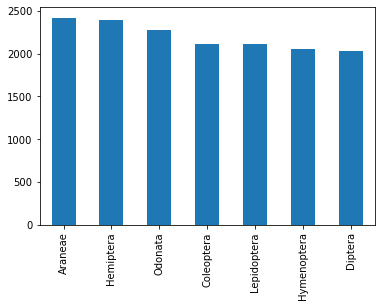

In [4]:

train_data = data
count_col = train_data.labels.value_counts()
count_col.plot(kind = 'bar')

## Data label encoded

In [5]:
LB = LabelEncoder()
data['encoded labels']= LB.fit_transform(data['labels'])
data.head()

,images,labels,encoded labels
0,0019ce6cda02.jpg,Araneae,0
1,003eb3db1665.jpg,Araneae,0
2,00594c648f4d.jpg,Araneae,0
3,007e1a3a7667.jpg,Araneae,0
4,00befcd5211d.jpg,Araneae,0


In [6]:
dataset = len(data)
range(dataset)

range(0, 15376)

In [7]:
from sklearn.model_selection import train_test_split
train_list, val_list = train_test_split(data.labels, stratify = data.labels, test_size=0.3)

## Train Validation split using Numpy

In [8]:
dataset_size = len(data)
shuffle_dataset = True
random_seed= 42
indices = list(range(dataset_size))
split = int(np.floor(0.3 * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_ind, val_ind = indices[split:], indices[:split]

In [9]:
print(f"Train data: {len(train_list)}")
print(f"valid data: {len(val_list)}")


Train data: 10763
valid data: 4613


In [10]:
print(f"Train data: {len(train_ind)}")
print(f"valid data: {len(val_ind)}")


Train data: 10764
valid data: 4612


## Dataset

In [11]:

class ArTax_dataset(Dataset):
    def __init__(self,img_path,img_data,transform=None):
        self.img_path = img_path
        self.img_data = img_data
        self.transform = transform

    def __len__(self):
        return len(self.img_data)

    def __getitem__(self,index):
        img = os.path.join(self.img_path, self.img_data.loc[index, 'labels'], self.img_data.loc[index, 'images'])
        image = Image.open(img)
        label = torch.tensor(self.img_data.loc[index,'encoded labels'])
        if self.transform is not None:
            image = self.transform(image)
        return image, label


## Data Augmentation

In [12]:

train_transform=transforms.Compose([
          transforms.Resize((224,224)),
          transforms.RandomVerticalFlip(),
          transforms.RandomRotation(20),
          transforms.ToTensor(),
          transforms.RandomHorizontalFlip(p=0.7),
          transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                std=[0.229, 0.224, 0.225])
                              ]
        )

valid_transform=transforms.Compose([
          transforms.Resize((224,224)),
          transforms.ToTensor(),
          transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                std=[0.229, 0.224, 0.225])
                              ]
        )

## Datasets and dataloaders

In [13]:

train_sampler = SubsetRandomSampler(train_ind)
valid_sampler = SubsetRandomSampler(val_ind)

In [14]:

train_dataset = ArTax_dataset(img_data=data, img_path=Path, transform=train_transform)
valid_dataset = ArTax_dataset(img_data=data, img_path=Path, transform=valid_transform)

In [15]:
trainloader= torch.utils.data.DataLoader(train_dataset, batch_size=64, sampler=train_sampler)
print(len(trainloader))
validloader= torch.utils.data.DataLoader(valid_dataset, batch_size=64, sampler=valid_sampler)
print(len(validloader))


169
73


## visualization

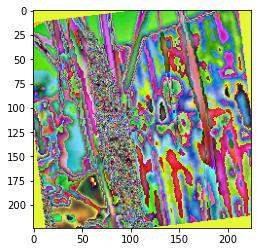

In [16]:
#commentout the normalization in cifar10 train data to see unnormalized img
npimg = next(iter(trainloader))[0][0]
plt.imshow(transforms.ToPILImage()(npimg))


## Train data visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images.shape: torch.Size([64, 3, 224, 224])


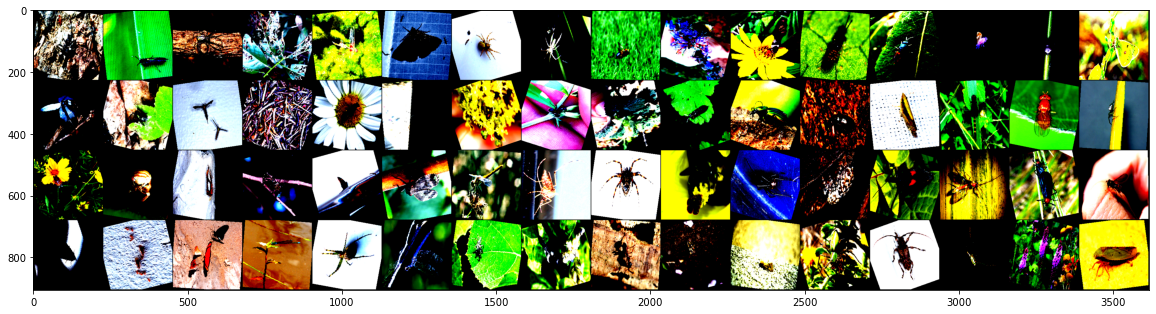

In [17]:
from torchvision.utils import make_grid
for images, _ in trainloader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(20,10))
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

## Valididation data visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images.shape: torch.Size([64, 3, 224, 224])


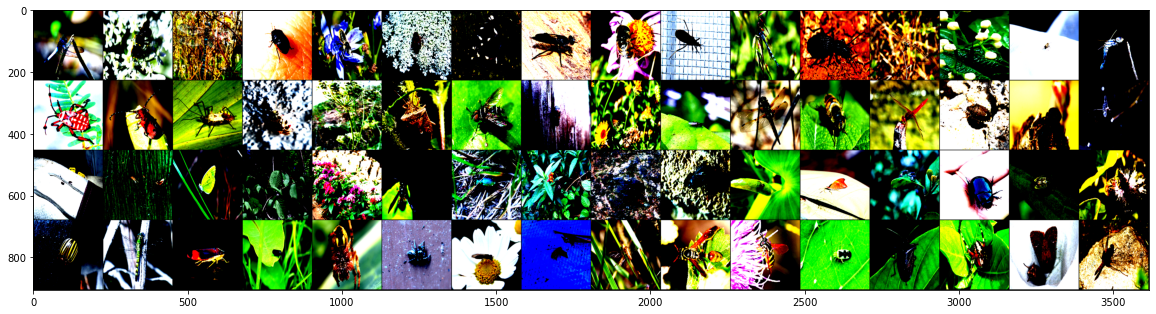

In [18]:
for images, _ in validloader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(20,10))
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [19]:
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f"Training on device : {device}.")

Training on device : cuda.


## Baseline Model Architecture

In [21]:
class net(nn.Module): #take 32*32 input image and 73% validacc with lr=e4, bs=64, epoch=20
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1, stride=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1, stride=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1, stride=1)
        self.fc1 = nn.Linear(100352, 1024) #512*2*2
        self.fc2 = nn.Linear(1024, 7)
        

    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = F.max_pool2d(torch.relu(self.conv3(out)), 2)
        out = F.max_pool2d(torch.relu(self.conv4(out)), 2)

        out = out.view(out.size(0), -1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)

        return out



## Training Loop

In [22]:
import datetime

def TrainingLoop (epoch, model, loss_fn, optimizer, trainloader):

    train_epochLoss_hist = []
    train_epochAcc_hist = []
    valid_epochLoss_hist = []
    valid_epochAcc_hist = []
    for epoch in range(1, epoch+1):
         
         epoch_loss = 0
         train_correct = 0
         train_total = 0
         for data, label in trainloader:
            label = label.type(torch.LongTensor) #to avoid runtime error
            data = data.to(device)
            label = label.to(device)
        
            output = model(data)
            loss = loss_fn(output, label)
        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss +=loss.item()
            _,tpredicted = torch.max(output, dim=1)
            train_total += label.shape[0]
            train_correct += int((tpredicted == label).sum())
            
            train_epochLoss = (epoch_loss/len(trainloader))
            train_epochAcc = (float(train_correct) / float(train_total) * 100)

         if epoch == 1 or epoch %10 == 0:
          print(f"Loss in train epoch {epoch} : {epoch_loss/len(trainloader)} : date and time : {datetime.datetime.now()} : Got {train_correct} / {train_total} with train accuracy of :{float(train_correct) / float(train_total) * 100:.2f}")
          train_epochLoss_hist.append(train_epochLoss)
          train_epochAcc_hist.append(train_epochAcc)
    
         with torch.no_grad():
              valid_loss = 0
              correct = 0
              total = 0
              for data, label in validloader:
                  label = label.type(torch.LongTensor)
                  data = data.to(device=device)
                  label = label.to(device=device)
            # Forward Pass
                  val_output = model(data)
                  val_loss = loss_fn(val_output, label)
                  valid_loss += val_loss.item()
                  _, vpredicted = torch.max(val_output, dim=1)
                  total += label.shape[0]
                  correct += int((vpredicted == label).sum())

                  valid_epochLoss = (valid_loss/len(validloader))
                  valid_epochAcc = (float(correct) / float(total) * 100)
              if epoch == 1 or epoch %10 == 0:
               print(
                   f"Loss in Valid epoch {epoch} : {valid_loss/len(validloader)} : Got {correct} / {total} with valid accuracy of :{float(correct) / float(total) * 100:.2f}")
               valid_epochLoss_hist.append(valid_epochLoss)
               valid_epochAcc_hist.append(valid_epochAcc)
        
    import matplotlib.pyplot as plt

    valid_losses = valid_epochLoss_hist
    train_losses = train_epochLoss_hist

    plt.figure(figsize=(10,5))
    plt.title("Training and Validation Loss")
    plt.plot(valid_losses,label="val")
    plt.plot(train_losses,label="train")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    valid_acc = valid_epochAcc_hist
    train_acc = train_epochAcc_hist

    plt.figure(figsize=(10,5))
    plt.title("Training and Validation Accuracy")
    plt.plot(valid_acc,label="val")
    plt.plot(train_acc,label="train")
    plt.xlabel("iterations")
    plt.ylabel("accuracy")
    plt.legend()
    plt.show()

In [24]:
model = net().to(device=device) #remove () from net with transfer learning models
optimizer = optim.SGD(model.parameters(), lr=1e-2) 
loss_fn = nn.CrossEntropyLoss()


Loss in train epoch 1 : 1.938072991794383 : date and time : 2022-04-16 17:46:08.687546 : Got 1789 / 10764 with train accuracy of :16.62
Loss in Valid epoch 1 : 1.9300554043626132 : Got 734 / 4612 with valid accuracy of :15.92
Loss in train epoch 10 : 1.7803401227533464 : date and time : 2022-04-16 20:14:10.394064 : Got 3283 / 10764 with train accuracy of :30.50
Loss in Valid epoch 10 : 1.7879430463869277 : Got 1342 / 4612 with valid accuracy of :29.10
Loss in train epoch 20 : 1.6840977802784485 : date and time : 2022-04-16 22:54:06.193102 : Got 3799 / 10764 with train accuracy of :35.29
Loss in Valid epoch 20 : 1.9142119361929697 : Got 1147 / 4612 with valid accuracy of :24.87


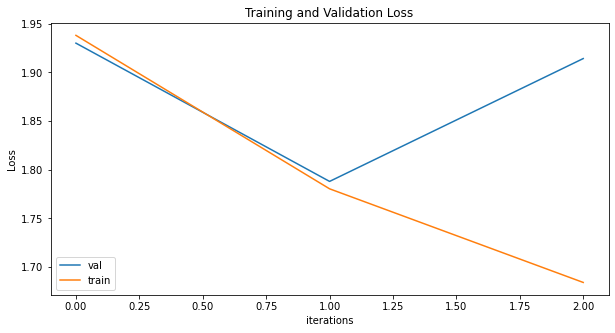

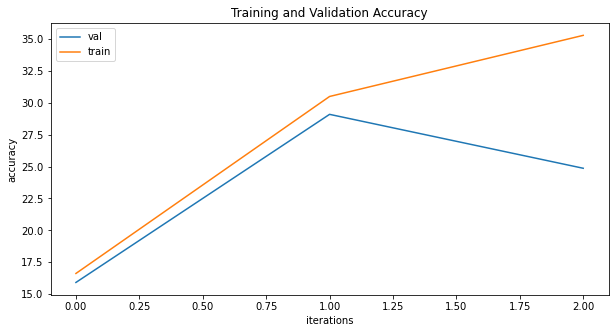

In [25]:

 
TrainingLoop(
      epoch = 20,
      optimizer = optimizer,
      model = model,
      loss_fn = loss_fn,
      trainloader = trainloader,
 )



## overfitting
 The above graph shows model started overfitting after 10 epochs.

## saving and Loading the model

In [26]:
torch.save(model.state_dict(), "net_ArTax.pt") #save the model

In [29]:
model = net()
model.load_state_dict(torch.load("/CV_projects/Arthropod_tax/ArTaxOr/net_ArTax.pt"))
model.eval()

net(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=100352, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=7, bias=True)
)

## Validation accuracy

In [30]:

total = 0
correct = 0

with torch.no_grad():
    for imgs, labels in validloader:
                imgs = imgs.to(device="cpu")
                labels = labels.to(device="cpu")
                output = model(imgs)
                _, predicted = torch.max(output, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
    print(
              f"Got {correct} / {total} with test accuracy {float(correct) / float(total) * 100:.2f}"
)


Got 1147 / 4612 with test accuracy 24.87
